# Crop original image

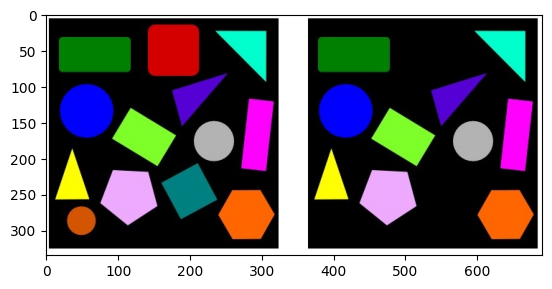

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

base_im = cv2.cvtColor(cv2.imread('./original.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(base_im)

In [8]:
cols = base_im.mean(axis=2).mean(axis=0)
rows = base_im.mean(axis=2).mean(axis=1)
print(np.where(cols > 200))
print(np.where(rows > 200))

(array([  0,   1,   2,   3, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 685, 686, 687, 688, 689, 690]),)
(array([  0,   1,   2,   3,   4,   5, 326, 327, 328, 329, 330, 331, 332,
       333, 334]),)


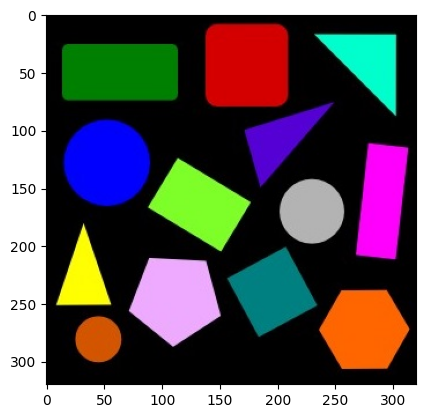

In [9]:
b = base_im[6:326, 4:324]
q = base_im[6:326, 365:685]
plt.imshow(b)
# cv2.imwrite()

# Obj det

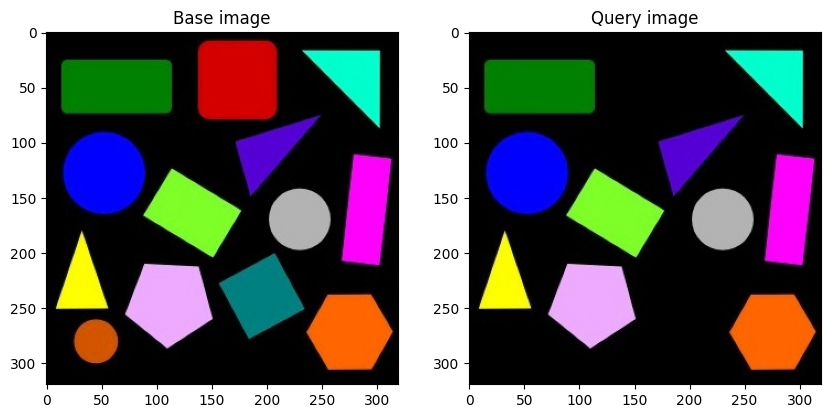

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


base = cv2.imread('b.jpg')
query = cv2.imread('q.jpg')
_, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(base)
axes[0].set_title('Base image')
axes[1].imshow(query)
axes[1].set_title('Query image')
plt.savefig('result1.jpg')

In [11]:
def find_box_center(box):
    return ((box[1] + box[3]) // 2, (box[0] + box[2]) // 2)

def detect_objects_by_contour(raw, show=False):
    # keep the most intense channel
    img = raw.max(axis=2)
    # binarization
    _, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    # find contour
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # calculate bounding boxes
    bboxes = []
    for points in contours:
        ctr = np.vstack(points)
        l, t, r, b = ctr[:, 1].min(), ctr[:, 0].min(), ctr[:, 1].max(), ctr[:, 0].max()
        bboxes.append((l, t, r, b))
    # visualization
    if show:
        _, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes[0, 0].set_title('Original')
        axes[0, 0].imshow(raw)
        axes[0, 1].set_title('Binarized')
        axes[0, 1].imshow(thresh)
        axes[1, 0].set_title('Contours')
        cont = cv2.drawContours(base.copy(), contours, -1, (255,255,255), 3)
        axes[1][0].imshow(cont)
        axes[1, 1].set_title('Bounding boxes')
        tmp = raw.copy()
        for i, b in enumerate(bboxes):
            boxed = cv2.rectangle(tmp, (b[1], b[0]), (b[3], b[2]), (0, 255, 255), 2)
            cv2.putText(tmp, str(i), find_box_center(b), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0)
        axes[1, 1].imshow(boxed)
    return bboxes

Found 13 objects in base image.


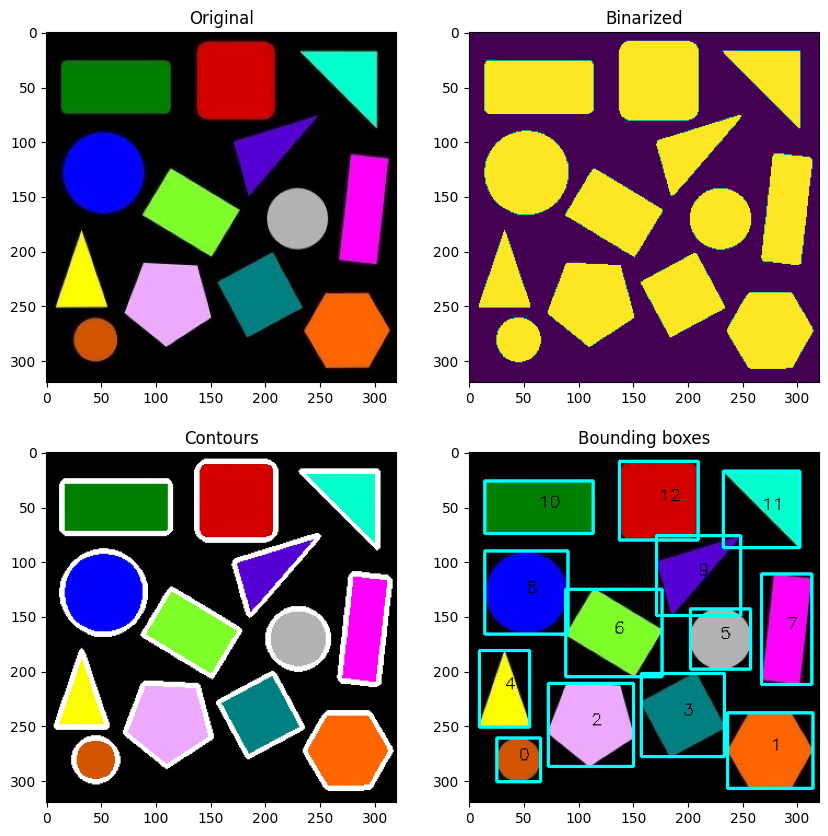

In [12]:
bboxes = detect_objects_by_contour(base, show=True)
qboxes = detect_objects_by_contour(query)
print(f"Found {len(bboxes)} objects in base image.")

# Feature extraction & matching

In [13]:
ORB = cv2.ORB_create(edgeThreshold=0, fastThreshold=10)

def extract_feature_from_bbox(img, bboxes):
    crop_features = []
    for b in bboxes:
        crop = img[b[0]-1:b[2] + 2, b[1]-1:b[3] + 2]
        crop_features.append(ORB.detectAndCompute(crop, None))
    return crop_features

base_crops = extract_feature_from_bbox(base, bboxes)
query_crops = extract_feature_from_bbox(query, qboxes)

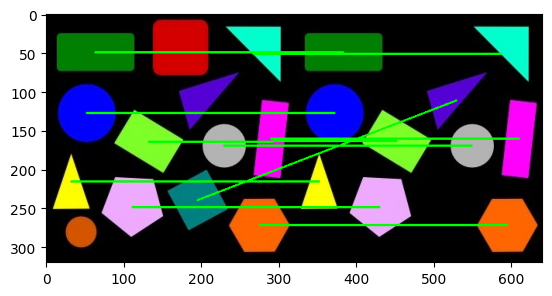

In [14]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def find_best_match(patch1, patch2):
    # mean of all pair-wise distance between two lists of key points
    dist_matrix = np.array([[cdist(d1, d2).mean() for _, d1 in patch1] for _, d2 in patch2])
    match_idxes = linear_sum_assignment(dist_matrix)
    return match_idxes

def draw_matches(img1, img2, matched_kps):
    new = np.hstack([img1, img2])
    for pt1, pt2 in matched_kps:
        new_pt2 = (pt2[0] + img1.shape[1], pt2[1])
        new = cv2.line(new, (pt1[0], pt1[1]), (new_pt2[0], new_pt2[1]), (0, 255, 0), 2)
    plt.imshow(new)

match_idxes = find_best_match(base_crops, query_crops)
# find matched objects for vis
match_pts = []
for query_idx, base_idx in zip(*match_idxes):
    bbox = bboxes[base_idx]
    qbox = qboxes[query_idx]
    match_pts.append((find_box_center(bbox), find_box_center(qbox)))

draw_matches(base, query, match_pts)

In [15]:
missing_idx = set(range(len(base_crops))) - set(match_idxes[1])
print(f"{len(missing_idx)} objects are missing in query image. Their positions are {[find_box_center(bboxes[i]) for i in missing_idx]}")

3 objects are missing in query image. Their positions are [(45, 281), (209, 112), (173, 44)]
